# Bayesian Neural Network Auto Encoder

<div class="alert alert-info">
<p>In this notebook we run several architecture configurations for a bayesian neural autoencoder network.
The network is trained using bayesian inference and therefore maximizing a lower bound, the ELBO.</p>

<p>We train the networks using 10 Monte-Carlo samples from the posterior distribution over the weights. This gives us an estimate of the expected log-likelihood.</p>

<p>We always investigate how well the models perform on test data (test log-likelihood) and measure their denoising capabilities (test log-likelihood of reconstructions from noisy inputs from the test data).</p>

<p>Moreover, we visualize the latent space and its sampled reconstruction.</p>
</div>

In [2]:
import numpy as np
import time
import gc

In [3]:
from models.bayesian_autoencoder import BayesianAutoencoder

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
import tensorflow as tf

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# One hidden layer: 32

In [5]:
n_inputs = 784
n_neurons_encoder = []
n_latent = 32
n_neurons_decoder = []
vi = BayesianAutoencoder('BAE_32',
                         n_inputs,
                         n_neurons_encoder,
                         n_latent,
                         n_neurons_decoder,
                         constant_prior=False)
vi.learn(learning_rate=0.001, epochs=30)
print('Test Log-Likelihood: %.6f' % vi.benchmark())
vi.serialize('DUMPS/'+ vi.name + '/model.ckpt')

   [22.7] Epoch: 01 | NELBO: 10875365.139860 | ELL: -197.704078 | KL: 1640.908732 | Val. ELL: -135.933303
   [45.7] Epoch: 02 | NELBO: 6574372.324009 | ELL: -119.532617 | KL: 78.358478 | Val. ELL: -104.479809
   [68.9] Epoch: 03 | NELBO: 5290638.569930 | ELL: -96.192775 | KL: 35.975920 | Val. ELL: -88.255810
   [92.9] Epoch: 04 | NELBO: 4611306.803030 | ELL: -83.841485 | KL: 25.100333 | Val. ELL: -80.014442
   [119.0] Epoch: 05 | NELBO: 4312263.871795 | ELL: -78.404436 | KL: 19.914978 | Val. ELL: -76.862012
   [143.4] Epoch: 06 | NELBO: 4196224.403846 | ELL: -76.294635 | KL: 19.500373 | Val. ELL: -75.706397
   [170.5] Epoch: 07 | NELBO: 4136679.692890 | ELL: -75.212018 | KL: 18.725140 | Val. ELL: -74.790902
   [197.0] Epoch: 08 | NELBO: 4100965.034382 | ELL: -74.562655 | KL: 19.029649 | Val. ELL: -74.151130
   [226.9] Epoch: 09 | NELBO: 4076692.705711 | ELL: -74.121403 | KL: 15.526474 | Val. ELL: -73.912464
   [251.0] Epoch: 10 | NELBO: 4056355.603147 | ELL: -73.751680 | KL: 13.204990 

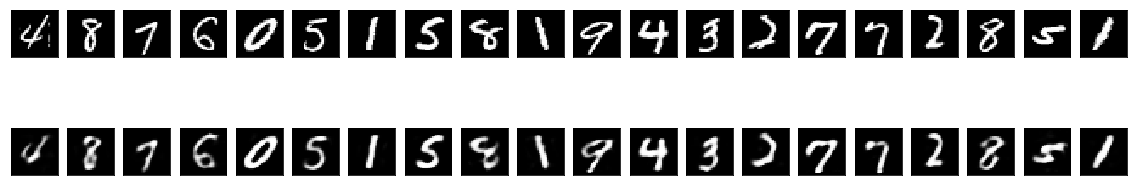

In [7]:
vi.plot_enc_dec(20, save=True)

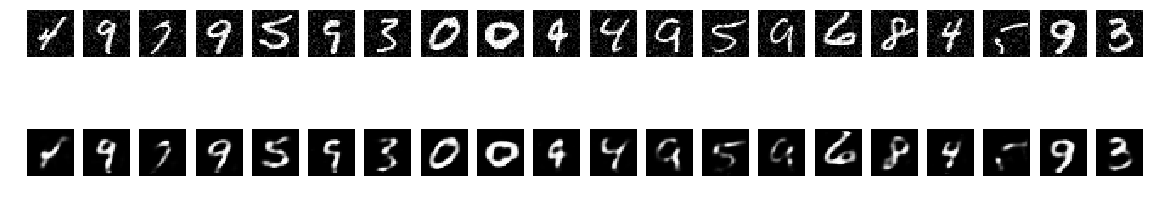

In [17]:
vi.plot_noisy_recon(20, save=True)

In [9]:
print('Test Log-Likelihood after noisy reconstruction: %.6f' % vi.benchmark(noisy=True))

Test Log-Likelihood after noisy reconstruction: -75.631032


# 256x128x2x128x256

In [9]:
n_inputs = 784
n_neurons_encoder = [256, 128]
n_latent = 2
n_neurons_decoder = [128, 256]
vi = BayesianAutoencoder('BAE_256_128_2',
                         n_inputs,
                         n_neurons_encoder,
                         n_latent,
                         n_neurons_decoder,
                         constant_prior=False)
vi.learn(learning_rate=0.001, epochs=50, mc_samples=10)
print('Test Log-Likelihood: %.6f' % vi.benchmark())
vi.serialize('DUMPS/'+ vi.name + '/model.ckpt')

   [44.7] Epoch: 01 | NELBO: 12096648.685315 | ELL: -219.664376 | KL: 15107.997043 | Val. ELL: -198.516362
   [105.6] Epoch: 02 | NELBO: 10531095.557110 | ELL: -191.470299 | KL: 229.111952 | Val. ELL: -183.678128
   [156.1] Epoch: 03 | NELBO: 9840275.508159 | ELL: -178.912950 | KL: 63.293953 | Val. ELL: -172.822088
   [214.8] Epoch: 04 | NELBO: 9308327.130536 | ELL: -169.241375 | KL: 51.490042 | Val. ELL: -163.811203
   [276.8] Epoch: 05 | NELBO: 8873977.622378 | ELL: -161.344123 | KL: 50.850948 | Val. ELL: -157.291960
   [323.5] Epoch: 06 | NELBO: 8591733.043124 | ELL: -156.212476 | KL: 46.869985 | Val. ELL: -153.039944
   [379.1] Epoch: 07 | NELBO: 8358522.483683 | ELL: -151.972331 | KL: 44.230687 | Val. ELL: -149.044586
   [425.9] Epoch: 08 | NELBO: 8189173.265734 | ELL: -148.893221 | KL: 46.086624 | Val. ELL: -146.401532
   [486.1] Epoch: 09 | NELBO: 8025125.982517 | ELL: -145.910565 | KL: 44.889470 | Val. ELL: -143.338649
   [548.8] Epoch: 10 | NELBO: 7904086.186480 | ELL: -143.70

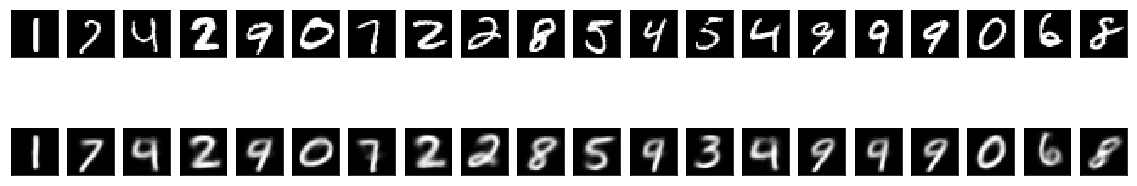

In [10]:
vi.plot_enc_dec(20, save=True)

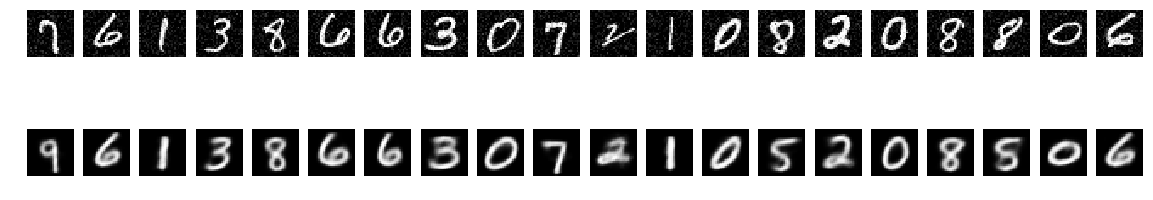

In [12]:
vi.plot_noisy_recon(20, save=True)

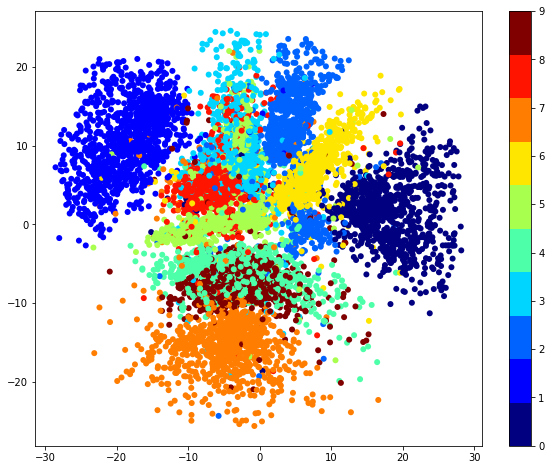

In [11]:
vi.plot_latent_repr(save=True)

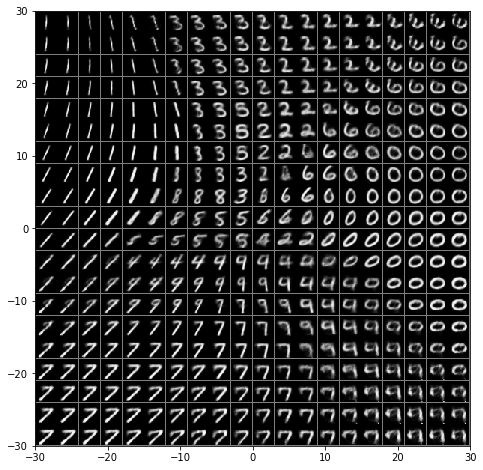

In [14]:
vi.plot_latent_recon(l_min=-30, l_max=30, save=True)

In [10]:
print('Test Log-Likelihood after noisy reconstruction: %.6f' % vi.benchmark(noisy=True))

Test Log-Likelihood after noisy reconstruction: -143.579895


# 256x128x3x128x256

In [13]:
n_inputs = 784
n_neurons_encoder = [256, 128]
n_latent = 3
n_neurons_decoder = [128, 256]
vi = BayesianAutoencoder('BAE_256_128_3',
                         n_inputs,
                         n_neurons_encoder,
                         n_latent,
                         n_neurons_decoder,
                         constant_prior=False)
vi.learn(learning_rate=0.001, epochs=50, mc_samples=10)
print('Test Log-Likelihood: %.6f' % vi.benchmark())
vi.serialize('DUMPS/'+ vi.name + '/model.ckpt')

   [50.8] Epoch: 01 | NELBO: 11873085.825175 | ELL: -215.599411 | KL: 15118.216638 | Val. ELL: -187.835374
   [102.2] Epoch: 02 | NELBO: 9807040.787879 | ELL: -178.305799 | KL: 221.834314 | Val. ELL: -168.945968
   [149.8] Epoch: 03 | NELBO: 9074949.567599 | ELL: -164.997341 | KL: 95.814744 | Val. ELL: -159.210044
   [195.9] Epoch: 04 | NELBO: 8656303.257576 | ELL: -157.385963 | KL: 75.277979 | Val. ELL: -153.322563
   [248.4] Epoch: 05 | NELBO: 8359143.947552 | ELL: -151.983093 | KL: 73.785454 | Val. ELL: -148.050113
   [297.2] Epoch: 06 | NELBO: 8138007.092075 | ELL: -147.962474 | KL: 71.008925 | Val. ELL: -144.096288
   [343.3] Epoch: 07 | NELBO: 7973254.710956 | ELL: -144.966999 | KL: 69.734500 | Val. ELL: -142.075576
   [396.3] Epoch: 08 | NELBO: 7830371.132867 | ELL: -142.369234 | KL: 63.269340 | Val. ELL: -140.055656
   [455.2] Epoch: 09 | NELBO: 7723785.381119 | ELL: -140.431399 | KL: 58.442497 | Val. ELL: -138.844042
   [514.4] Epoch: 10 | NELBO: 7625501.044289 | ELL: -138.644

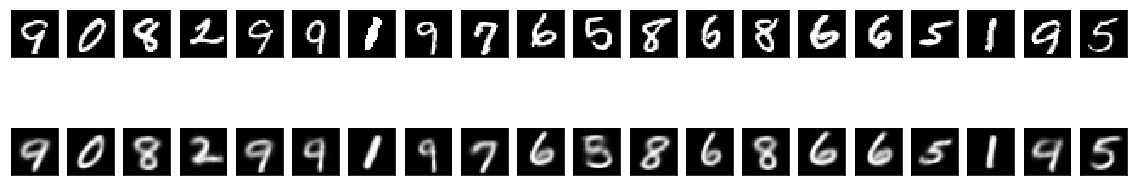

In [15]:
vi.plot_enc_dec(20, save=True)

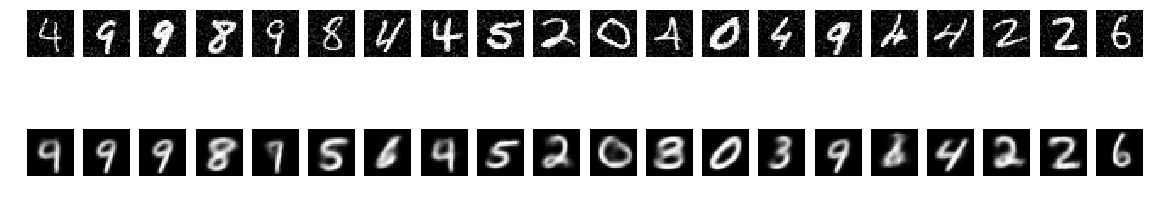

In [12]:
vi.plot_noisy_recon(20, save=True)
print('Test Log-Likelihood after noisy reconstruction: %.6f' % vi.benchmark(noisy=True))

In [13]:
print('Test Log-Likelihood after noisy reconstruction: %.6f' % vi.benchmark(noisy=True))

Test Log-Likelihood after noisy reconstruction: -143.779877


# 256x128x32x128x256

In [16]:
n_inputs = 784
n_neurons_encoder = [256, 128]
n_latent = 32
n_neurons_decoder = [128, 256]
vi = BayesianAutoencoder('BAE_256_128_32',
                         n_inputs,
                         n_neurons_encoder,
                         n_latent,
                         n_neurons_decoder,
                         constant_prior=False)
vi.learn(learning_rate=0.001, epochs=50, mc_samples=10)
print('Test Log-Likelihood: %.6f' % vi.benchmark())
vi.serialize('DUMPS/'+ vi.name + '/model.ckpt')

   [59.2] Epoch: 01 | NELBO: 11877869.787879 | ELL: -215.661080 | KL: 16510.382568 | Val. ELL: -182.755021
   [121.2] Epoch: 02 | NELBO: 8688744.516317 | ELL: -157.970645 | KL: 359.057734 | Val. ELL: -142.372577
   [168.9] Epoch: 03 | NELBO: 7471842.328671 | ELL: -135.849187 | KL: 137.035418 | Val. ELL: -129.781227
   [227.4] Epoch: 04 | NELBO: 6940307.043124 | ELL: -126.185662 | KL: 95.613247 | Val. ELL: -120.903495
   [289.3] Epoch: 05 | NELBO: 6569184.844988 | ELL: -119.438402 | KL: 72.721910 | Val. ELL: -116.499979
   [346.8] Epoch: 06 | NELBO: 6360893.469697 | ELL: -115.651521 | KL: 59.833066 | Val. ELL: -112.846593
   [398.9] Epoch: 07 | NELBO: 6185901.467366 | ELL: -112.469918 | KL: 55.946430 | Val. ELL: -110.086710
   [445.1] Epoch: 08 | NELBO: 6005367.277389 | ELL: -109.187493 | KL: 55.148437 | Val. ELL: -107.028694
   [491.1] Epoch: 09 | NELBO: 5808672.192308 | ELL: -105.611212 | KL: 55.526619 | Val. ELL: -103.760195
   [537.4] Epoch: 10 | NELBO: 5614293.601399 | ELL: -102.07

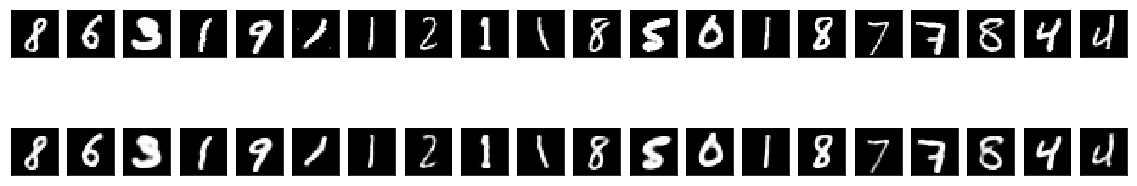

In [18]:
vi.plot_enc_dec(20, save=True)

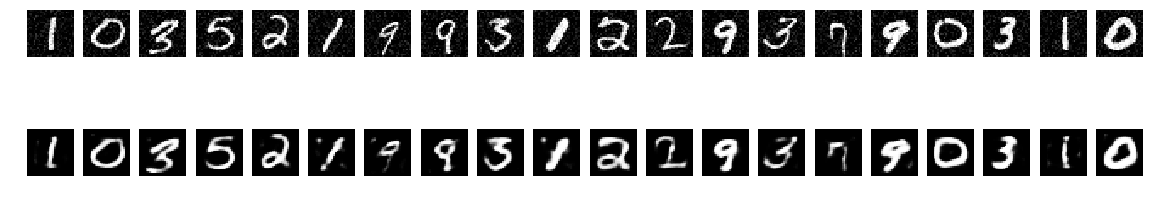

In [17]:
vi.plot_noisy_recon(20, save=True)

In [18]:
print('Test Log-Likelihood after noisy reconstruction: %.6f' % vi.benchmark(noisy=True))

Test Log-Likelihood after noisy reconstruction: -96.098001


# 128x64x2x64x128

In [5]:
n_inputs = 784
n_neurons_encoder = [128, 64]
n_latent = 2
n_neurons_decoder = [64, 128]
vi = BayesianAutoencoder('BAE_128_64_2',
                         n_inputs,
                         n_neurons_encoder,
                         n_latent,
                         n_neurons_decoder,
                         constant_prior=False)
vi.learn(learning_rate=0.001, epochs=50, mc_samples=10)
print('Test Log-Likelihood: %.6f' % vi.benchmark())
vi.serialize('DUMPS/'+ vi.name + '/model.ckpt')

   [30.1] Epoch: 01 | NELBO: 12520563.100233 | ELL: -227.517475 | KL: 7101.997471 | Val. ELL: -198.798640
   [60.4] Epoch: 02 | NELBO: 10723485.009324 | ELL: -194.970068 | KL: 131.295099 | Val. ELL: -191.797586
   [92.1] Epoch: 03 | NELBO: 10331277.524476 | ELL: -187.840647 | KL: 41.907550 | Val. ELL: -183.655781
   [125.0] Epoch: 04 | NELBO: 9949955.911422 | ELL: -180.907707 | KL: 32.008135 | Val. ELL: -177.277460
   [157.3] Epoch: 05 | NELBO: 9657102.440559 | ELL: -175.583146 | KL: 29.427143 | Val. ELL: -173.187886
   [190.4] Epoch: 06 | NELBO: 9473167.603730 | ELL: -172.238876 | KL: 29.400097 | Val. ELL: -169.824763
   [222.4] Epoch: 07 | NELBO: 9309431.310023 | ELL: -169.262009 | KL: 20.835188 | Val. ELL: -167.190037
   [254.9] Epoch: 08 | NELBO: 9163538.489510 | ELL: -166.609413 | KL: 20.746744 | Val. ELL: -164.274299
   [286.6] Epoch: 09 | NELBO: 9036087.768065 | ELL: -164.292135 | KL: 20.337033 | Val. ELL: -162.302711
   [318.0] Epoch: 10 | NELBO: 8905243.016317 | ELL: -161.9131

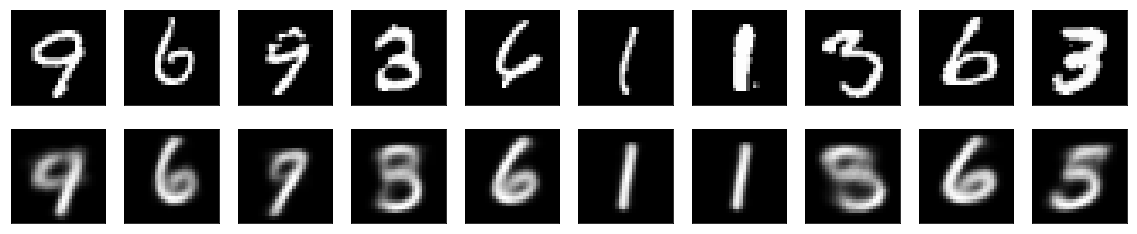

In [8]:
vi.plot_enc_dec(10, save=True)

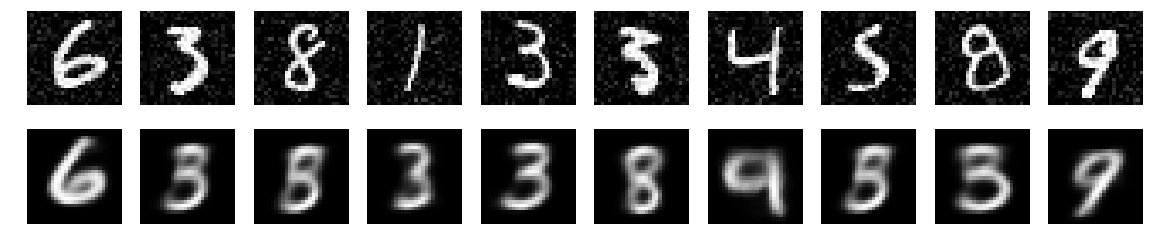

In [9]:
vi.plot_noisy_recon(10, save=True)

In [10]:
print('Test Log-Likelihood after noisy reconstruction: %.6f' % vi.benchmark(noisy=True))

Test Log-Likelihood after noisy reconstruction: -153.989799


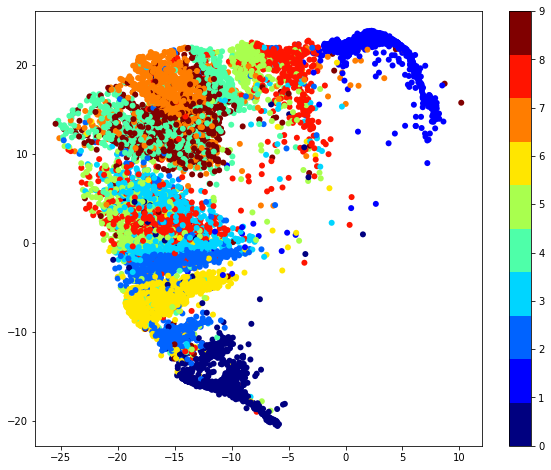

In [10]:
vi.plot_latent_repr(save=True)

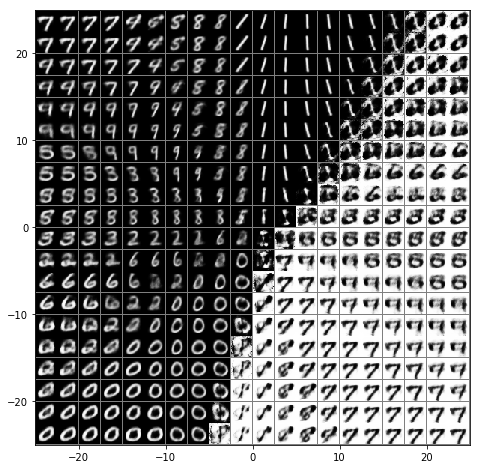

In [11]:
vi.plot_latent_recon(l_min=-25, l_max=25, save=True)

# 128x64x3x64x128

In [5]:
n_inputs = 784
n_neurons_encoder = [128, 64]
n_latent = 3
n_neurons_decoder = [64, 128]
vi = BayesianAutoencoder('BAE_128_64_3',
                         n_inputs,
                         n_neurons_encoder,
                         n_latent,
                         n_neurons_decoder,
                         constant_prior=False)
vi.learn(learning_rate=0.001, epochs=50, mc_samples=10)
print('Test Log-Likelihood: %.6f' % vi.benchmark())
vi.serialize('DUMPS/'+ vi.name + '/model.ckpt')

   [29.1] Epoch: 01 | NELBO: 12595920.421911 | ELL: -228.887020 | KL: 7134.308998 | Val. ELL: -198.801969
   [60.8] Epoch: 02 | NELBO: 10741075.426573 | ELL: -195.290021 | KL: 124.228078 | Val. ELL: -192.465347
   [96.3] Epoch: 03 | NELBO: 10397667.571096 | ELL: -189.047833 | KL: 36.774059 | Val. ELL: -185.158912
   [132.5] Epoch: 04 | NELBO: 9768108.086247 | ELL: -177.601388 | KL: 31.656184 | Val. ELL: -169.425784
   [163.8] Epoch: 05 | NELBO: 9089086.751748 | ELL: -165.255696 | KL: 23.493419 | Val. ELL: -160.778446
   [196.9] Epoch: 06 | NELBO: 8714654.131702 | ELL: -158.447833 | KL: 23.334012 | Val. ELL: -154.753461
   [234.7] Epoch: 07 | NELBO: 8446532.641026 | ELL: -153.572914 | KL: 22.386221 | Val. ELL: -150.582446
   [268.8] Epoch: 08 | NELBO: 8261854.896270 | ELL: -150.215138 | KL: 22.249192 | Val. ELL: -147.907058
   [305.1] Epoch: 09 | NELBO: 8107974.567599 | ELL: -147.417327 | KL: 21.539276 | Val. ELL: -145.074546
   [338.9] Epoch: 10 | NELBO: 7992976.305361 | ELL: -145.3264

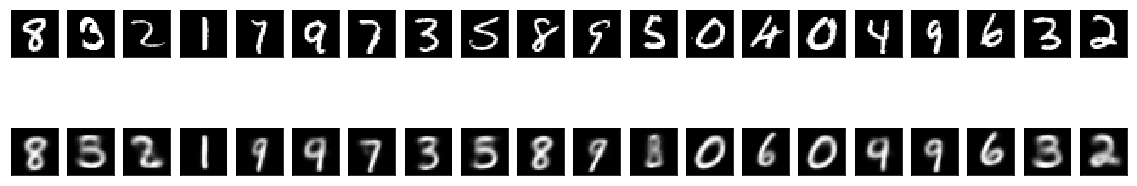

In [7]:
vi.plot_enc_dec(20, save=True)

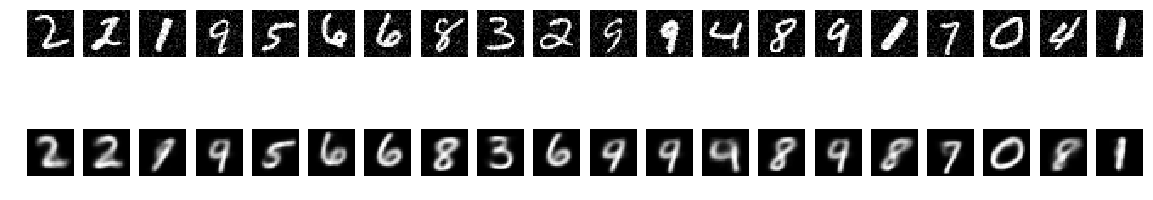

In [27]:
vi.plot_noisy_recon(20, save=True)

In [28]:
print('Test Log-Likelihood after noisy reconstruction: %.6f' % vi.benchmark(noisy=True))

Test Log-Likelihood after noisy reconstruction: -147.327414


# 128x64x32x64x128

In [8]:
n_inputs = 784
n_neurons_encoder = [128, 64]
n_latent = 32
n_neurons_decoder = [64, 128]
vi = BayesianAutoencoder('BAE_128_64_32',
                         n_inputs,
                         n_neurons_encoder,
                         n_latent,
                         n_neurons_decoder,
                         constant_prior=False)
vi.learn(learning_rate=0.001, epochs=50, mc_samples=10)
print('Test Log-Likelihood: %.6f' % vi.benchmark())
vi.serialize('DUMPS/'+ vi.name + '/model.ckpt')

   [33.5] Epoch: 01 | NELBO: 12520738.170163 | ELL: -227.508774 | KL: 7755.564233 | Val. ELL: -198.509928
   [64.1] Epoch: 02 | NELBO: 10620459.979021 | ELL: -193.096150 | KL: 171.739699 | Val. ELL: -187.797253
   [95.5] Epoch: 03 | NELBO: 9946691.459207 | ELL: -180.847670 | KL: 69.601469 | Val. ELL: -167.832794
   [127.2] Epoch: 04 | NELBO: 8870103.818182 | ELL: -161.273762 | KL: 46.899210 | Val. ELL: -154.747043
   [161.9] Epoch: 05 | NELBO: 8258098.388112 | ELL: -150.146567 | KL: 37.185413 | Val. ELL: -143.415631
   [200.7] Epoch: 06 | NELBO: 7776653.354312 | ELL: -141.393119 | KL: 31.795172 | Val. ELL: -137.327521
   [237.8] Epoch: 07 | NELBO: 7499799.998834 | ELL: -136.359462 | KL: 29.593885 | Val. ELL: -132.375811
   [277.1] Epoch: 08 | NELBO: 7276682.315851 | ELL: -132.302835 | KL: 26.387949 | Val. ELL: -129.534156
   [313.7] Epoch: 09 | NELBO: 7103398.713287 | ELL: -129.152240 | KL: 25.545623 | Val. ELL: -125.928405
   [348.3] Epoch: 10 | NELBO: 6940333.048951 | ELL: -126.18740

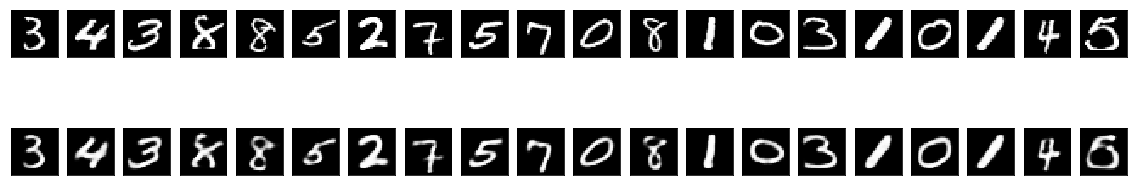

In [9]:
vi.plot_enc_dec(20, save=True)

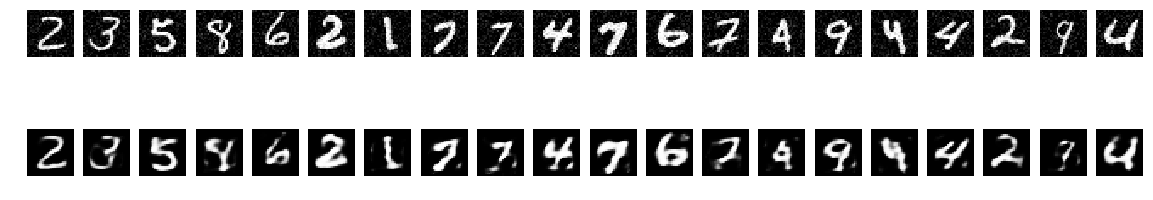

In [30]:
vi.plot_noisy_recon(20, save=True)

In [31]:
print('Test Log-Likelihood after noisy reconstruction: %.6f' % vi.benchmark(noisy=True))

Test Log-Likelihood after noisy reconstruction: -101.752110


# Restore models

In [6]:
n_inputs = 784
n_neurons_encoder = [128, 64]
n_latent = 2
n_neurons_decoder = [64, 128]
vi = BayesianAutoencoder('BAE_128_64_2',
                         n_inputs,
                         n_neurons_encoder,
                         n_latent,
                         n_neurons_decoder,
                         constant_prior=False)
vi.restore('DUMPS/' + vi.name + '/model.ckpt')

INFO:tensorflow:Restoring parameters from DUMPS/BAE_128_64_2/model.ckpt
